In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy as sp
import seaborn as sn
from pandas import rolling_mean
import matplotlib.pylab as pl
%matplotlib inline

import os 
import hedfpy

from hedfpy.EDFOperator import EDFOperator
from hedfpy.HDFEyeOperator import HDFEyeOperator
from hedfpy.EyeSignalOperator import EyeSignalOperator, detect_saccade_from_data

sn.set(style="ticks")
import warnings
warnings.filterwarnings("ignore")

from PIL import Image

In [3]:
os.chdir('../../experiments/PR/')
# input file name
edf_file = os.path.expanduser('~/shared/data/PR/tk_1_2017-10-17_16.59.06.edf')

low_pass_pupil_f, high_pass_pupil_f = 6.0, 0.01
alias = 'PR_1'

# initialize the hdfeyeoperator
ho = HDFEyeOperator(os.path.splitext(edf_file)[0] + '.h5')
# insert the edf file contents only when the h5 is not present.
if not os.path.isfile(os.path.splitext(edf_file)[0] + '.h5'):
    ho.add_edf_file(edf_file)
    ho.edf_message_data_to_hdf(alias = alias)
    ho.edf_gaze_data_to_hdf(alias = alias, pupil_hp = high_pass_pupil_f, pupil_lp = low_pass_pupil_f)

## load the data from the hdf5 file.

We'll print some of the outputs just to show you what's contained in the file

In [6]:
parameters = ho.read_session_data(alias, 'parameters')
parameters.head(5)

,answer,coherent_dots_duration,fixation_duration,random_dots1_duration,random_dots2_duration,trial_nr
0,1.0,1.217516,30.0,3.846415,3.224749,0.0
1,1.0,1.610352,0.0,1.958785,1.527419,1.0
2,0.0,4.842974,0.0,1.894047,1.509736,2.0
3,1.0,3.907155,0.0,1.532149,1.022386,3.0
4,0.0,1.876577,0.0,1.624312,1.444150,4.0


In [7]:
trial_phases = ho.read_session_data(alias, 'trial_phases')
trial_phases.head(5)

,trial_phase_trial,trial_phase_EL_timestamp,trial_phase_index,trial_phase_exp_timestamp
0,0.0,757260,1.0,66.0
1,0.0,761104,2.0,69.8
2,0.0,762332,3.0,71.0
3,1.0,765596,1.0,74.3
4,1.0,767572,2.0,76.3


In [8]:
trials = ho.read_session_data(alias, 'trials')
trials.head(5)

,trial_start_EL_timestamp,trial_start_index,trial_start_exp_timestamp,trial_end_EL_timestamp,trial_end_index,trial_end_exp_timestamp
0,749481.0,0,58.2,765595.0,0,74.3
1,765595.0,1,74.3,770766.0,1,79.5
2,770766.0,2,79.5,779084.0,2,87.8
3,779084.0,3,87.8,785597.0,3,94.3
4,785597.0,4,94.3,790617.0,4,99.3


In [9]:
screen_dims = ho.screen_dimensions_during_trial(alias=alias,trial_nr=0)
pix_per_degrees = screen_dims[0] / 40.0 # the screen @ this distance is 40 degrees wide.

## First, dividing everything up into trials.

We combine information from the tables with the gaze data.

In [12]:
coherent_times = np.array(trial_phases[trial_phases['trial_phase_index'] == 2]['trial_phase_EL_timestamp'])
incoherent_times = np.array(trial_phases[trial_phases['trial_phase_index'] == 3]['trial_phase_EL_timestamp'])

gaze_during_coherence = [
    np.array(
        ho.data_from_time_period(alias=alias, columns=['L_gaze_x_int','L_gaze_y_int'], time_period=(tp[0]-250,tp[1]+250))
            ) for tp in zip(coherent_times, incoherent_times)]

## Again, plot some single trials to see what's up.

What happens with the gaze direction, i.e. velocity, when coherency is suddenly increased? Recall that we only changed the coherence in the x-direction, so that should be the direction we look at. 

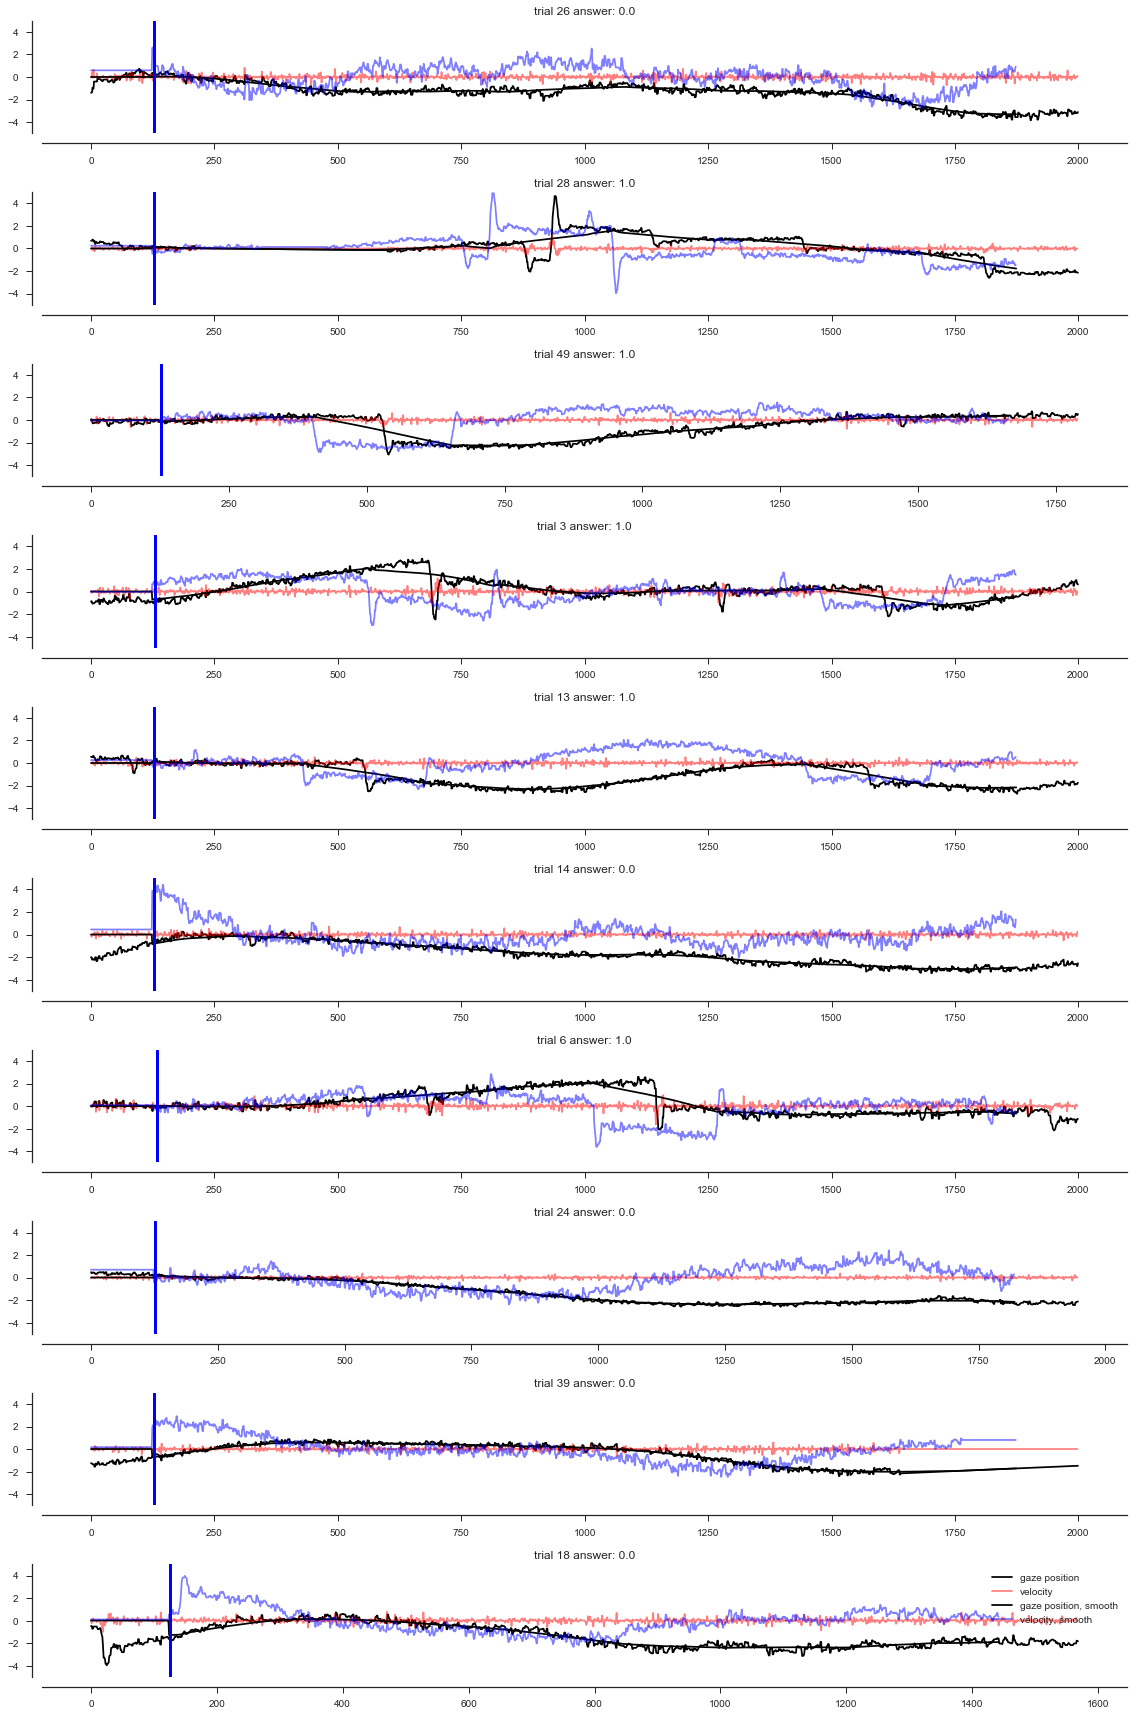

In [45]:
# just a handy function to make sure everything is scaled the same way.
def zscore(x):
    return (x-x.mean()) / x.std()

# smoothing width
smw = 250
s2 = int(smw/2)

# which trials to plot
which_trials = np.random.choice(np.arange(len(parameters)), size=10, replace=False)
f = pl.figure(figsize = (16,24))
for i, trial in enumerate(which_trials):
    s = f.add_subplot(len(which_trials),1,i+1)
    gd = zscore(gaze_during_coherence[trial][:2000,0])
    gd -= gd[250]
    pl.plot(gd, 'k', label='gaze position')
    pl.plot(np.diff(gd), 'r', label='velocity', alpha=0.5)
    
    pl.plot(np.nan_to_num(rolling_mean(gd, smw))[s2:], 'k', label='gaze position, smooth')
    pl.plot(zscore(np.nan_to_num(rolling_mean(np.diff(gd), smw)))[s2:], 'b', label='velocity, smooth', alpha=0.5)

    s.axvline(x=parameters.coherent_dots_duration[trial]+s2, c='b', lw=3)
    s.set_title('trial ' + str(trial) + ' answer: ' + str(parameters.answer[trial]))
    s.set_ylim([-5,5])

    sn.despine(ax=s, offset=10)
pl.legend()
pl.tight_layout()